In [1]:
import os

In [2]:
import xml.etree.ElementTree as ET
import pygraphviz as pgv

def build_graph(element, graph, parent=None):
    node_label = element.tag
    if parent is not None:
        graph.add_edge(parent, node_label)
    for child in element:
        build_graph(child, graph, node_label)

# Parse the XML file
path = os.environ['SIM_MODEL_PATH'] + 'wall_outler/model.sdf'
# tree = ET.parse('/home/athimeta/CARVER-Savvy/carverabwu/src/abwu_gazebo/worlds/abwu_drl_base.world')
tree = ET.parse(path)
root = tree.getroot()

# Create a directed graph
graph = pgv.AGraph(strict=False, directed=True)

# Build the graph
build_graph(root, graph)

# Export the graph to a PNG file
graph.layout(prog='dot')  # Use dot layout engine
graph.draw('xml_structure.png')


In [3]:
NO_GOAL_SPAWN_MARGIN = 0.0
path = os.environ['SIM_MODEL_PATH'] + 'wall_outler/model.sdf'
tree = ET.parse(path)
root = tree.getroot()
obstacle_coordinates = []
pos_list = []
size_list = []
for wall in root.find('model').findall('link'):
    pose = wall.find('pose').text.split(" ")
    size = wall.find('collision').find('geometry').find('box').find('size').text.split()
    pos_list.append(pose)
    size_list.append(size)
    pose_x = float(pose[0])
    pose_y = float(pose[1])
    # Check if the wall is rotated
    # If the wall is rotated the size is swapped for x and y
    # rotation = 0 means horizontal wall
    # rotation != 0 means vertical wall
    rotation = float(pose[-1])
    if rotation == 0: # if the wall is not rotated the size is correct
        size_x = float(size[0]) + NO_GOAL_SPAWN_MARGIN * 2
        size_y = float(size[1]) + NO_GOAL_SPAWN_MARGIN * 2
    else: # if the wall is rotated the size is swapped for x and y
        size_x = float(size[1]) + NO_GOAL_SPAWN_MARGIN * 2
        size_y = float(size[0]) + NO_GOAL_SPAWN_MARGIN * 2
    point_1 = [pose_x + size_x / 2, pose_y + size_y / 2]
    point_2 = [point_1[0], point_1[1] - size_y]
    point_3 = [point_1[0] - size_x, point_1[1] - size_y ]
    point_4 = [point_1[0] - size_x, point_1[1] ]
    wall_points = [point_1, point_2, point_3, point_4]
    obstacle_coordinates.append(wall_points)
    wall_name = wall.get('name')
    print(f'WALL: {wall_name} pose: {pose}, size: {size}')

obstacle_coordinates


WALL: Wall_1 pose: ['-0', '-7.425', '0', '0', '-0', '0'], size: ['15', '0.15', '2.5']
WALL: Wall_2 pose: ['7.425', '-0', '0', '0', '-0', '1.5708'], size: ['15', '0.15', '2.5']
WALL: Wall_3 pose: ['-0', '7.425', '0', '0', '-0', '3.14159'], size: ['15', '0.15', '2.5']
WALL: Wall_4 pose: ['-7.425', '-0', '0', '0', '-0', '-1.5708'], size: ['15', '0.15', '2.5']


[[[7.5, -7.35], [7.5, -7.5], [-7.5, -7.5], [-7.5, -7.35]],
 [[7.5, 7.5], [7.5, -7.5], [7.35, -7.5], [7.35, 7.5]],
 [[0.075, 14.925],
  [0.075, -0.07499999999999929],
  [-0.075, -0.07499999999999929],
  [-0.075, 14.925]],
 [[-7.35, 7.5], [-7.35, -7.5], [-7.5, -7.5], [-7.5, 7.5]]]

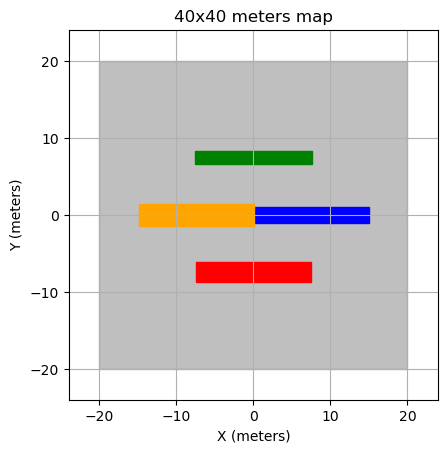

In [4]:
import math
import matplotlib.pyplot as plt

def draw_wall(ax, pose, size, color='black'):
  """
  This function draws a wall on a matplotlib axes object based on pose, size, and rotation data.

  Args:
      ax: The matplotlib axes object where the wall will be drawn.
      pose: A list containing pose data (assumed rotation is at index 2).
      size: A list containing wall dimensions (width, thickness, height).
      color: The color of the wall (defaults to black).
  """

  # Extract data from pose and size lists
  pose_rotation = math.radians(float(pose[-1]))  # Convert rotation to radians
  pose_x = float(pose[0])
  pose_y = float(pose[1])
  wall_width = float(size[0])
  wall_thickness = float(size[1])
  wall_height = float(size[2])

  # Calculate center point of the wall
  wall_center_x = pose_x
  wall_center_y = pose_y

  # Handle rotation using mathematical transformations
  # (This is a simplified example, more complex logic might be needed in specific cases)
  rotated_width = wall_width * math.cos(pose_rotation) + wall_height * math.sin(pose_rotation)
  rotated_height = wall_height * math.cos(pose_rotation) - wall_width * math.sin(pose_rotation)

  # Calculate start point based on rotated dimensions and center
  wall_start_x = wall_center_x - rotated_width / 2
  wall_start_y = wall_center_y - rotated_height / 2

  # Create rectangle object for the rotated wall
  wall_rectangle = plt.Rectangle((wall_start_x, wall_start_y), rotated_width, rotated_height, color=color)

  # Add wall rectangle to the plot
  ax.add_patch(wall_rectangle)


# Define map dimensions (meters)
map_width = 40
map_height = 40

# Create figure and axes
fig, ax = plt.subplots()

# Set limits slightly bigger than map dimensions (for visualization purposes)
plt.xlim(-map_width/2 - map_width * 0.1, map_width/2 + map_width * 0.1)
plt.ylim(-map_height/2 - map_height * 0.1, map_height/2 + map_height * 0.1)

# Set aspect ratio to be equal
ax.set_aspect("equal")

# Create rectangle object with origin at center
rectangle = plt.Rectangle((-map_width/2, -map_height/2), map_width, map_height, color='gray', alpha=0.5)

# Add rectangle to the figure
ax.add_patch(rectangle)

clors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i, (pose, size) in enumerate(zip(pos_list, size_list)):
  # Draw wall
  draw_wall(ax, pose, size, color=clors[i])

# Set labels
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')

# Set title (optional)
plt.title(f'{map_width}x{map_height} meters map')

# Show the plot
plt.grid(True)
plt.show()

In [5]:
import os

print(os.environ['ABWUDRL_BASE_PATH'])
print(os.environ['GAZEBO_MODEL_PATH'])

print(os.environ['GAZEBO_MODEL_PATH'])
print(os.environ['GAZEBO_PLUGIN_PATH'])


/home/athimeta/CARVER-Savvy/carverabwu
:/home/athimeta/CARVER-Savvy/carverabwu/src/abwu_gazebo/models
:/home/athimeta/CARVER-Savvy/carverabwu/src/abwu_gazebo/models
:/home/athimeta/CARVER-Savvy/carverabwu/src/abwu_gazebo/models/turtlebot3_drl_world/obstacle_plugin/lib


In [6]:
import numpy as np
MAX_NUMBER_OBSTACLES = 10
[np.inf] * MAX_NUMBER_OBSTACLES

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]